In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table,vstack
%matplotlib inline
import json
import pandas as pd
import sncosmo
import sys
sys.path.append('/home/mi/Desktop/project-sn-fitter/project')
import sedfit.utils
import sedfit.mangle
import pickle
from astropy.convolution import Gaussian1DKernel, convolve
from scipy.interpolate import interp2d,interp1d
import spectres

In [2]:
## load source
source = pickle.load(open('sn2005hk.source.pickle', "rb" ) )['source']

In [3]:
def load_test_data(datafile):
    data = pd.read_json(datafile)
    name = datafile.split('.json')[0].split('/')[-1]
    data = data[name]
    print name
    redshift = float(data['redshift'][0]['value'])
    print 'redshift=',redshift
    photometry = pd.read_json(pd.DataFrame(data['photometry']).to_json(),orient='column')
    print(photometry.columns)
    photometry.rename(columns={x: x.encode('ascii') for x in photometry.columns})
    photometry = Table.from_pandas(photometry)    
    photometry['Filter'] = photometry['band']
    photometry['Mag'] = photometry['magnitude']
    photometry['MagErr'] = photometry['e_magnitude']
    photometry['MJD'] = photometry['time']
    photometry['Survey'] = photometry['telescope']
    
    phot = photometry['Filter','Mag','MagErr','MJD','Survey','system','source'][~photometry['Mag'].mask]
    phot['Survey'][phot['Survey'] == 'Swope 1.0m'] = 'CSP-S'
    phot['Filter'][phot['Survey'] == 'CSP-S'] = [x+'S' for x in phot['Filter'][phot['Survey']=='CSP-S']]
    phot['Survey'][phot['Survey'] == 'CSP-S'] = 'CSP'

    phot['Survey'][phot['Survey'] == 'du Pont 2.5m'] = 'CSP-D'
    phot['Filter'][phot['Survey']=='CSP-D'] = [x+'D' for x in phot['Filter'][phot['Survey']=='CSP-D']]
    phot['Survey'][phot['Survey'] == 'CSP-D'] = 'CSP'
    
    phot['Survey'][phot['Survey'] == 'PAIRITEL'] = 'CfAIR2'
    phot['Survey'][phot['Survey'] == 'CfA'] = 'CfA4'
    
    phot = phot['Filter','Mag','MagErr','MJD','Survey'][~phot['Survey'].mask]
    phot['Filter'][phot['Survey']=='SDSS'] = [x[0:1] for x in phot['Filter'][phot['Survey']=='SDSS']]
    phot['Filter'][phot['Filter']=='Ks'] = 'K_s'
    a1 = phot['Filter']
    c = ("-" * len(phot))
    a2 = phot['Survey']
    phot['Filter'] = map(''.join, zip(a2, c, a1))
    phot['Filter'][phot['Survey']=='CfA3'] = [x+'K' for x in phot['Filter'][phot['Survey']=='CfA3']]
    phot['Filter'][phot['Filter']=='CfA4-r'] = "CfA4-r'"
    phot['Filter'][phot['Filter']=='CfA4-i'] = "CfA4-i'"
    
    phot = phot[~phot['MagErr'].mask]
    phot['Survey'] = [str(x) for x in phot['Survey']]
    return phot,redshift

In [4]:
def plot_model_lc(phot,redshift,source,peakmjd):
    sedmodel = sncosmo.Model(source=source)
    sedmodel.set(z=redshift)
    synlc_phase = np.arange(-14,63,1)
    fig = plt.figure(figsize=(18,15))
    j=0
    for i,f in enumerate(set(phot['Filter'])):
        try:
            band = sncosmo.get_bandpass(f)
        except:
            continue
        plt.subplot(6,5,j+1)
        plt.title(f)
        if band.minwave()< sedmodel.minwave() or band.maxwave()> sedmodel.maxwave():
            continue
        mref,magsys = sedfit.utils.get_refmag(f.split('-')[0],f.split('-')[-1])
        synlc_mag = sedmodel.bandmag(band,magsys,synlc_phase) + mref
        plt.plot(synlc_phase*(1.+redshift),synlc_mag)
        plt.errorbar(phot['MJD'][phot['Filter']==f]-peakmjd,phot['Mag'][phot['Filter']==f],yerr=phot['MagErr'][phot['Filter']==f],fmt='o')
        plt.ylim(plt.ylim()[::-1])
        j+=1
    plt.tight_layout()
    plt.show()

SN2012Z
redshift= 0.007125
Index([u'band', u'e_fluxdensity', u'e_magnitude', u'fluxdensity', u'frequency',
       u'instrument', u'magnitude', u'source', u'system', u'telescope',
       u'time', u'u_fluxdensity', u'u_frequency', u'u_time', u'upperlimit'],
      dtype='object')


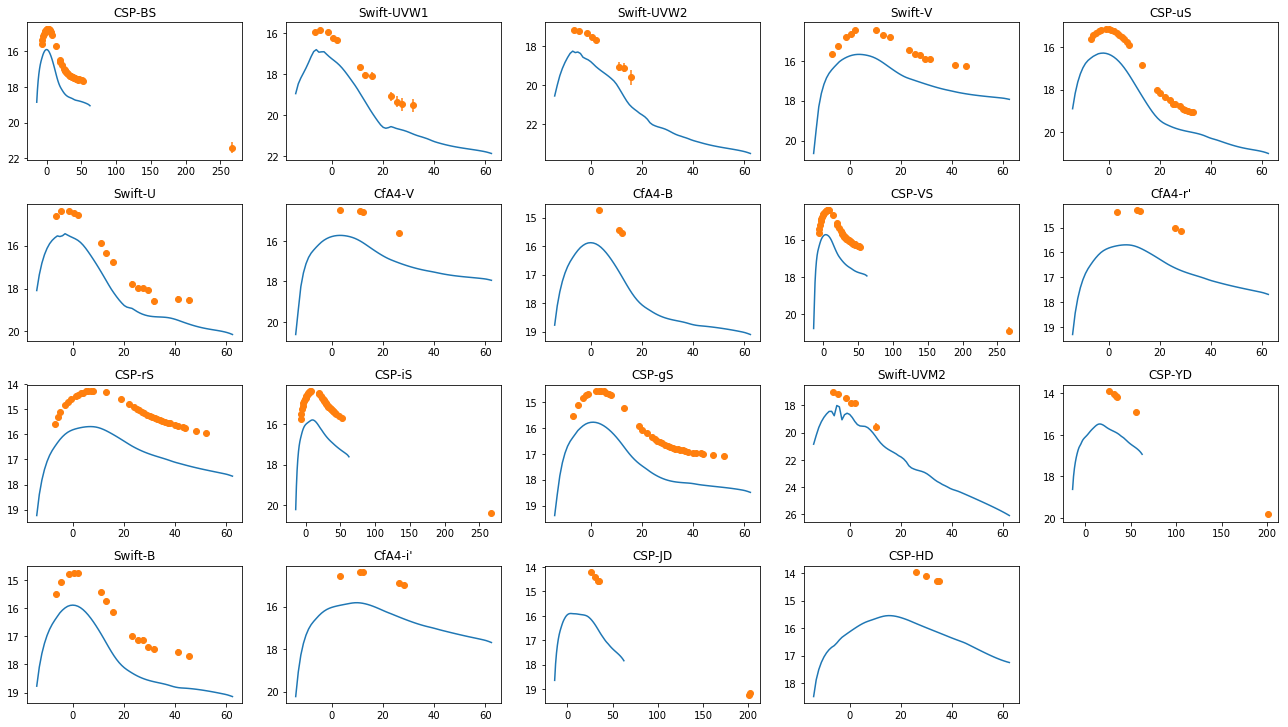

SN2008A
redshift= 0.016455
Index([u'band', u'bandset', u'e_fluxdensity', u'e_magnitude', u'fluxdensity',
       u'frequency', u'instrument', u'magnitude', u'source', u'system',
       u'telescope', u'time', u'u_fluxdensity', u'u_frequency', u'u_time',
       u'upperlimit'],
      dtype='object')


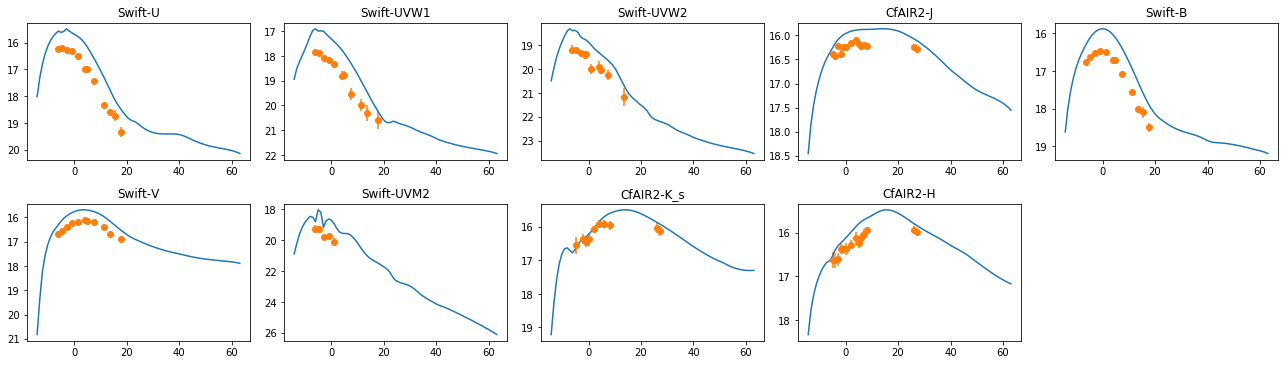

SN2008ae
redshift= 0.03006
Index([u'band', u'bandset', u'e_magnitude', u'instrument', u'magnitude',
       u'source', u'system', u'telescope', u'time', u'u_time', u'upperlimit'],
      dtype='object')


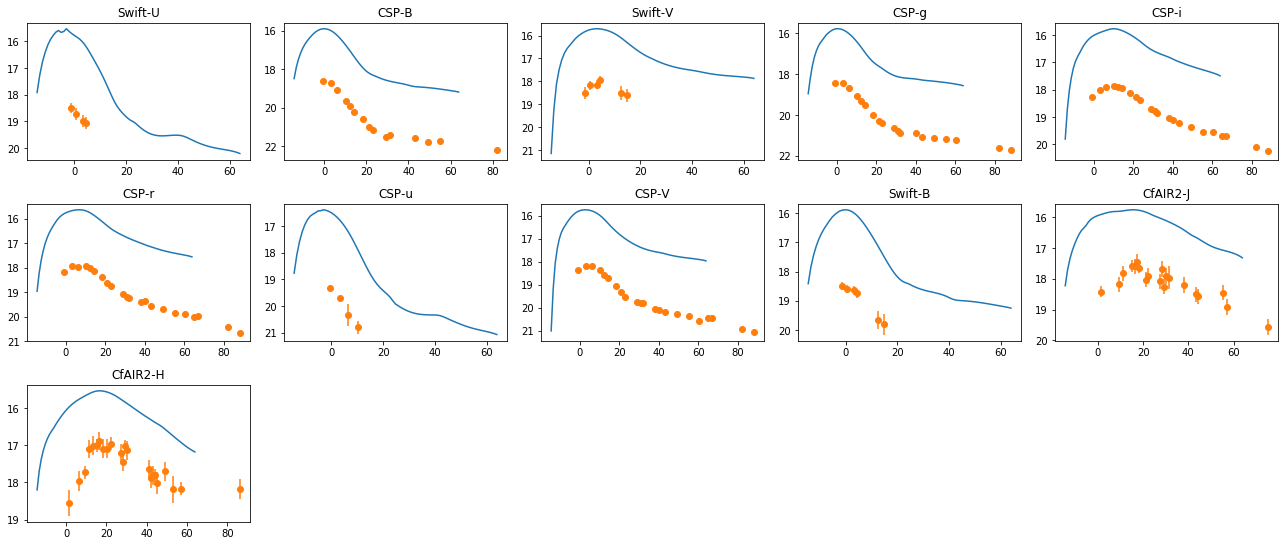

In [5]:
for name,peakmjd in zip(['2012Z','2008A','2008ae'],[55966.,54479.,54509.]):
    phot,redshift = load_test_data('../testphot/SN'+name+'.json')
    sedfit.utils.register_bands_for_sncosmo()
    plot_model_lc(phot,redshift,source,peakmjd)